# Run inference on time series of Sentinel-2 images

* **Last Modified**: 13-04-2021
* **Authors**: Gonzalo Mateo-García
---

This notebook shows how to download Sentinel-2 image time series over an area of interest (AoI) using the Google Earth Engine. Once these images are downloaded we show how to run inference on them to produce flood segmentation maps. Finally we vectorize the flood maps and display them on an interactive map.

In [1]:
# Install the ml4floods package
!pip install git+https://github.com/spaceml-org/ml4floods#egg=ml4floods

# authenticate in GEE
! earthengine authenticate

In [3]:
from datetime import datetime, timedelta, timezone
import geopandas as gpd
import pandas as pd
import ee
import geemap.eefolium as geemap
import folium
from ml4floods.data import ee_download
from shapely.geometry import mapping, shape
import matplotlib.pyplot as plt
import os

## Step 1: Config AoI and dates to search for S2 images

In [4]:
date_event = datetime.strptime("2021-02-12","%Y-%m-%d").replace(tzinfo=timezone.utc)

date_start_search = datetime.strptime("2021-01-15","%Y-%m-%d").replace(tzinfo=timezone.utc)
date_end_search = date_start_search + timedelta(days=45)

area_of_interest_geojson = {'type': 'Polygon',
 'coordinates': (((19.483318354000062, 41.84407200000004),
   (19.351701478000052, 41.84053242300007),
   (19.298659824000026, 41.871157520000054),
   (19.236388306000038, 41.89588351100008),
   (19.22956438700004, 42.086957306000045),
   (19.327827977000027, 42.09102668200006),
   (19.778082109000025, 42.10312055000003),
   (19.777652446000047, 41.97309238100007),
   (19.777572772000042, 41.94912981900006),
   (19.582705341000064, 41.94398333100003),
   (19.581417139000052, 41.94394820700006),
   (19.54282145700006, 41.90168177700008),
   (19.483318354000062, 41.84407200000004)),)}

area_of_interest = shape(area_of_interest_geojson)

def generate_polygon(bbox):
    """
    Generates a list of coordinates: [[x1,y1],[x2,y2],[x3,y3],[x4,y4],[x1,y1]]
    """
    return [[bbox[0],bbox[1]],
             [bbox[2],bbox[1]],
             [bbox[2],bbox[3]],
             [bbox[0],bbox[3]],
             [bbox[0],bbox[1]]]

## Step 2: Plot cloud coverage of available S2 image over AoI and search dates

Found 18 S2 images between 2021-02-12T00:00:00+00:00 and 2021-03-01T00:00:00+00:00


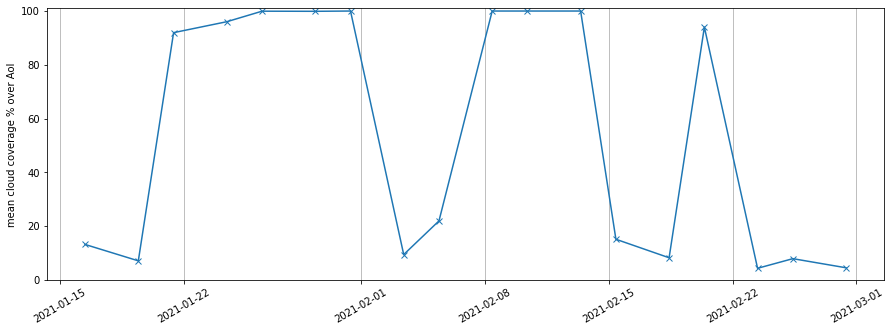

In [5]:
ee.Initialize()

bounds_pol = generate_polygon(area_of_interest.bounds)
pol_2_clip = ee.Geometry.Polygon(bounds_pol)

pol = ee.Geometry(area_of_interest_geojson)

# Grab the S2 images and the Permanent water image
img_col = ee_download.get_s2_collection(date_start_search, 
                                        date_end_search, pol)
permanent_water_img = ee_download.permanent_water_image(date_event.year, pol_2_clip)

# Get info of the S2 images (convert to table)
img_col_info = ee_download.img_collection_to_feature_collection(img_col, 
                                                                ["system:time_start", "valids", "cloud_probability"])

img_col_info_local = gpd.GeoDataFrame.from_features(img_col_info.getInfo())
img_col_info_local["system:time_start"] = img_col_info_local["system:time_start"].apply(lambda x: datetime.utcfromtimestamp(x/1000))

n_images_col = img_col_info_local.shape[0]
print(f"Found {n_images_col} S2 images between {date_event.isoformat()} and {date_end_search.isoformat()}")

plt.figure(figsize=(15,5))
plt.plot(img_col_info_local["system:time_start"], img_col_info_local["cloud_probability"],marker="x")
plt.ylim(0,101)
plt.xticks(rotation=30)
plt.ylabel("mean cloud coverage % over AoI")
plt.grid(axis="x")

In [6]:
img_col_info_local

,geometry,cloud_probability,system:time_start,valids
0,"POLYGON ((-180.00000 -90.00000, 180.00000 -90....",13.254181,2021-01-16 09:38:59.983,1
1,"POLYGON ((-180.00000 -90.00000, 180.00000 -90....",7.172355,2021-01-19 09:48:56.039,1
2,"POLYGON ((-180.00000 -90.00000, 180.00000 -90....",91.966141,2021-01-21 09:39:00.993,1
3,"POLYGON ((-180.00000 -90.00000, 180.00000 -90....",96.029202,2021-01-24 09:48:56.823,1
4,"POLYGON ((-180.00000 -90.00000, 180.00000 -90....",99.941818,2021-01-26 09:39:00.106,1
5,"POLYGON ((-180.00000 -90.00000, 180.00000 -90....",99.897624,2021-01-29 09:48:55.986,1
6,"POLYGON ((-180.00000 -90.00000, 180.00000 -90....",100.000000,2021-01-31 09:39:00.341,1
7,"POLYGON ((-180.00000 -90.00000, 180.00000 -90....",9.503629,2021-02-03 09:48:55.943,1
8,"POLYGON ((-180.00000 -90.00000, 180.00000 -90....",22.013119,2021-02-05 09:38:59.531,1
9,"POLYGON ((-180.00000 -90.00000, 180.00000 -90....",99.999951,2021-02-08 09:48:55.218,1


## Step 3: Display S2 images over the AoI

We loop over the available S2 images and show those with low cloud coverage

In [7]:
Map = geemap.Map()

imgs_list = img_col.toList(n_images_col, 0)
for i in range(n_images_col):
    if img_col_info_local.iloc[i]["cloud_probability"] > 75:
        continue
    img_show = ee.Image(imgs_list.get(i))
    
    Map.addLayer(img_show.clip(pol), 
                 {"min":0, "max":3000, 
                  "bands":["B11","B8","B4"]},
                 f"({i}/{n_images_col}) S2 SWIR/NIR/RED {img_col_info_local['system:time_start'][i].strftime('%Y-%m-%d')}", 
                 True)


visualization = {
  "bands": ['waterClass'],
  "min": 0.0,
  "max": 3.0,
  "palette": ['cccccc', 'ffffff', '99d9ea', '0000ff']
}

Map.addLayer(permanent_water_img, visualization, name="JRC Permanent water")

Map.addLayer(pol, {"color": 'FF000000'}, "AoI")

Map.centerObject(pol, zoom=11)
folium.LayerControl(collapsed=False).add_to(Map)
Map

In [8]:
img_show.get("cloud_probability").getInfo()

13.254181334133056

## Step 4: Download images to run inference

Change `export_to_gcp=False` to export to Google Drive if you're running this in Colab.


In [9]:
export_to_gcp = True

if export_to_gcp:
    # You need to create your own bucket and download the application credentials see: https://cloud.google.com/docs/authentication/getting-started. 
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/path/to/creds.json"
    path_to_export = "preingest/S2/"
    bucket_name = "ml4floods"
else:
    from google.colab import drive
    drive.mount('/content/drive')
    bucket_name = None
    path_to_export = "/content/drive/My Drive/"

In [10]:
export_task_fun_img = ee_download.export_task_image(
    bucket=bucket_name
)

bands_export = ee_download.BANDS_S2_NAMES["COPERNICUS/S2"] + ["probability"]

tasks = []
for i in range(n_images_col):
    if img_col_info_local.iloc[i]["cloud_probability"] > 75:
        continue
        
    img_export = ee.Image(imgs_list.get(i))
    img_export = img_export.select(bands_export).toFloat().clip(pol)
    
    date = img_col_info_local['system:time_start'][i].strftime('%Y%m%d')
    
    filename = f"{path_to_export}albania_ts_{date}"
    desc=f"albania_ts_{date}"
    task = ee_download.mayberun(
                        filename,
                        desc,
                        lambda: img_export,
                        export_task_fun_img,
                        overwrite=False,
                        dry_run=False,
                        bucket_name=bucket_name,
                        verbose=2,
                    )
    if task is not None:
        tasks.append(task)

ee_download.wait_tasks(tasks)

DefaultCredentialsError: File /path/to/creds.json was not found.

## Step 5: Check downloaded files

In [ ]:
if export_to_gcp:
    import fsspec
    fs = fsspec.filesystem("gs")
    exported_files = [f"gs://{f}" for f in fs.glob(f"gs://{bucket_name}/{path_to_export}albania_ts_*.tif")]
else:
    from glob import glob
    exported_files = glob(f"{path_to_export}albania_ts_*.tif")

exported_files

In [ ]:
from ml4floods.visualization import plot_utils

plot_utils.plot_s2_swirnirred_image(exported_files[0])

## Step 6: Run inference on the image time series

Now, we're going to load all the images that we've downloaded and run inference to compute flood extent estimations on them. See the [Run inference notebook](./HOWTO_Run_Inference_on_new_data.ipynb) for a detailed tutorial on this.

In [ ]:
from ml4floods.models.config_setup import get_default_config
from ml4floods.models.model_setup import get_model
from ml4floods.models.model_setup import get_model_inference_function

experiment_name = "WFV1_unet"
config_fp = f"gs://ml4cc_data_lake/2_PROD/2_Mart/2_MLModelMart/{experiment_name}/config.json"
config = get_default_config(config_fp)

# The max_tile_size param controls the max size of patches that are fed to the NN. If you're in a memory constrained environment set this value to 128
config["model_params"]["max_tile_size"] = 128

config["model_params"]['model_folder'] = 'gs://ml4cc_data_lake/2_PROD/2_Mart/2_MLModelMart'
config["model_params"]['test'] = True
model = get_model(config.model_params, experiment_name)
model.to("cuda")

inference_function = get_model_inference_function(model, config,apply_normalization=True)

In [ ]:
import torch
from ml4floods.data.worldfloods import dataset
from ml4floods.models.model_setup import get_channel_configuration_bands
import matplotlib.pyplot as plt
from ml4floods.visualization import plot_utils
from tqdm import tqdm
import numpy as np
from ml4floods.models import postprocess
import geopandas as gpd

channels = get_channel_configuration_bands(config.model_params.hyperparameters.channel_configuration)


In [ ]:
%%time

folder_save = "ts_outputs"
os.makedirs(folder_save, exist_ok=True)

for filename in tqdm(exported_files):
    # Load input
    torch_inputs, transform = dataset.load_input(filename, window=None, channels=channels)
    
    # Make predictions
    outputs = inference_function(torch_inputs.unsqueeze(0))[0] # (num_classes, h, w)
    prob_water_mask = outputs[1].cpu().numpy()
    binary_water_mask = prob_water_mask>.5
    prediction = torch.argmax(outputs, dim=0).long() # (h, w)
    mask_invalid = torch.all(torch_inputs == 0, dim=0)
    prediction+=1
    prediction[mask_invalid] = 0
    
    name_plot = os.path.splitext(os.path.basename(filename))[0]
    
    # Vectorize the output
    geoms_polygons = postprocess.get_water_polygons(binary_water_mask, transform=transform)
    vectorized_dataframe = gpd.GeoDataFrame({"geometry": geoms_polygons, "id": np.arange(len(geoms_polygons))})
    vectorized_dataframe.to_file(f"{folder_save}/{name_plot}.geojson", driver='GeoJSON')
    
    # Plot results
    fig, axs = plt.subplots(1,2, figsize=((16,4.5)))
    plot_utils.plot_s2_swirnirred_image(torch_inputs, transform=transform, ax=axs[0])
    plot_utils.plot_gt_v1(prediction.unsqueeze(0),transform=transform, ax=axs[1])
    fig.suptitle(datetime.strptime(filename[-12:-4],"%Y%m%d").strftime("%Y-%m-%d"),fontsize=20)
    plt.tight_layout()
    fig.savefig(f"{folder_save}/{name_plot}.jpg")
    fig.show()
    

## Step 7: Show vectorized floodmaps and S2 images in an interactive map

In [ ]:
Map = geemap.Map()

imgs_list = img_col.toList(n_images_col, 0)
for i in range(n_images_col):
    if img_col_info_local.iloc[i]["cloud_probability"] > 75:
        continue
    img_show = ee.Image(imgs_list.get(i))
    
    date_iter = img_col_info_local['system:time_start'][i]
    
    Map.addLayer(img_show.clip(pol), 
                 {"min":0, "max":3000, 
                  "bands":["B11","B8","B4"]},
                 f"{date_iter.strftime('%Y-%m-%d')} S2 SWIR/NIR/RED", 
                 True)
    
    name_plot = f"albania_ts_{date_iter.strftime('%Y%m%d')}"
    floodmap = gpd.read_file(f"{folder_save}/{name_plot}.geojson")
    name = f"FloodMap {date_iter.strftime('%Y-%m-%d')}"
    floodmap_folium = folium.features.GeoJson(floodmap, name=name, show=False)
    Map.add_child(floodmap_folium, name=name)


# Show JRC permanent water layer
visualization = {
  "bands": ['waterClass'],
  "min": 0.0,
  "max": 3.0,
  "palette": ['cccccc', 'ffffff', '99d9ea', '0000ff']
}

Map.addLayer(permanent_water_img, visualization, name="JRC Permanent water")

Map.addLayer(pol, {"color": 'FF000000'}, "AoI")

Map.centerObject(pol, zoom=11)
folium.LayerControl(collapsed=False).add_to(Map)
Map